In [4]:
from pathlib import Path
import sys

twodubem_path = str(Path().resolve().parent)
if twodubem_path not in sys.path:
    sys.path.append(twodubem_path)

In [9]:
import numpy as np
from twodubem import PolygonalBoundary, Solver
import matplotlib.pyplot as plt

In [10]:
def boundary_geometry(s):
    """Parametrized boundary.

    Parameters
    ----------
    s : float
        Parameter ranging from 0.0 to 1.0.

    Returns
    -------
    x : float
        Boundary point x coordinate.
    y : float
        Boundary point y coordinate.

    Raises
    ------
    ValueError
        If ``s`` is not a value ranging from 0.0 to 1.0.
    """

    if 0.0 <= s <= 0.25:
        x = 4.0*s
        y = 0.0
    elif 0.25 < s <= 0.50:
        x = 1.0
        y = 4.0*(s-0.25)
    elif 0.50 < s <= 0.75:
        x = 1.0 - 4.0*(s - 0.50)
        y = 1.0
    elif 0.75 < s <= 1.0:
        x = 0.0
        y = 1.0 - 4.0*(s - 0.75)
    else:
        raise ValueError("Parameter s must range from 0.0 to 1.0")

    return x, y

def boundary_condition(x, y):
    """Boundary condition type and value.

    Parameters
    ----------
    x : float
        Boundary point x coordinate.
    y : float
        Boundary point y coordinate.

    Returns
    -------
    bc_type : int
        Boundary condition type (0 for Dirichlet, 1 for Neumann).
    bc_value : float
        Boundary condition value.

    Raises
    ------
    ValueError
        If point (``x``, ``y``) is not located at the boundary.
    """

    if y == 0.0 and 0.0 <= x <= 1.0:
        bc_type = 1
        bc_value = 0
    elif x == 1.0 and 0.0 <= y <= 1.0:
        bc_type = 0
        bc_value = np.cos(np.pi * y)
    elif y == 1.0 and 0.0 <= x <= 1.0:
        bc_type = 1
        bc_value = 0
    elif x == 0.0 and 0.0 <= y <= 1.0:
        bc_type = 0
        bc_value = 0
    else:
        raise ValueError(f"Point ({x}, {y}) is not located at the boundary")

    return bc_type, bc_value

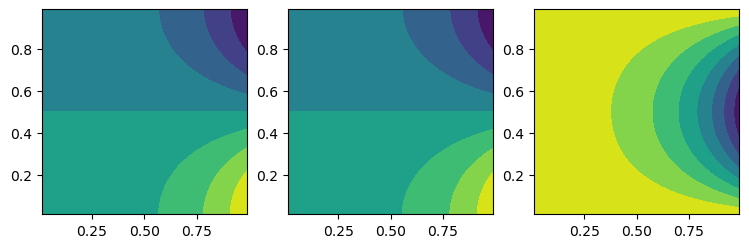

In [11]:
ua = lambda x, y: np.sinh(np.pi * x) * np.cos(np.pi * y) / np.sinh(np.pi)
uax = lambda x, y: np.pi * np.cosh(np.pi * x) * np.cos(np.pi * y) / np.sinh(np.pi)
uay = lambda x, y: -np.pi * np.sinh(np.pi * x) * np.sin(np.pi * y) / np.sinh(np.pi)

xv = np.linspace(0.01, 0.99, 99)
yv = np.linspace(0.01, 0.99, 99)
X, Y = np.meshgrid(xv, yv)

Ua = ua(X, Y)
Uax = uax(X, Y)
Uay = uay(X, Y)

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].contourf(X, Y, Ua)
ax[1].contourf(X, Y, Uax)
ax[2].contourf(X, Y, Uay)

for x in ax:
    x.set_aspect('equal')

plt.show()

In [12]:
bound = PolygonalBoundary(boundary_geometry, boundary_condition, 100)
bemp = Solver(bound)
bemp.solve()

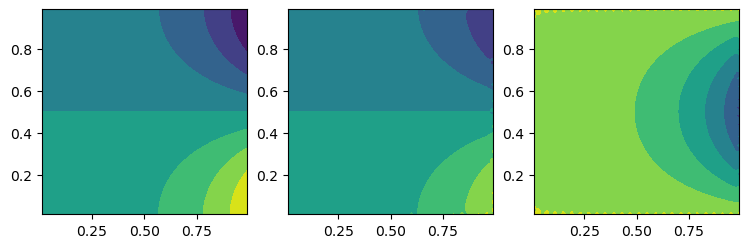

In [13]:
Z, W = bemp.get_interior_solution(X, Y, return_gradient=True)

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].contourf(X, Y, Z)
ax[1].contourf(X, Y, W[:, :, 0])
ax[2].contourf(X, Y, W[:, :, 1])

for x in ax:
    x.set_aspect('equal')

plt.show()

In [5]:
nv = 4 * np.array([4, 10, 20, 50, 100], dtype=np.int16)

# Zv = np.empty((len(nv),) + X.shape)
# Wv = np.empty((len(nv),) + X.shape + (2,))

# for i, n in enumerate(nv):
#     bound = Boundary(boundary_geometry, boundary_condition, n)
#     bemp = Solver(bound)
#     bemp.solve()
#     Zv[i], Wv[i] = bemp.get_interior_solution(X, Y)

# np.save('Zv.npy', Zv)
# np.save('Wv.npy', Wv)

Zv = np.load('Zv.npy')
Wv = np.load('Wv.npy')

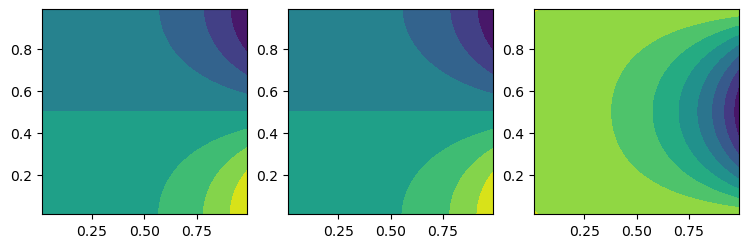

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].contourf(X, Y, Zv[-1])
ax[1].contourf(X, Y, Wv[-1, :, :, 0])
ax[2].contourf(X, Y, Wv[-1, :, :, 1])

for x in ax:
    x.set_aspect('equal')

plt.show()

In [28]:
Zerr = np.max(np.abs(Zv - Ua), axis=(1,2))
Wxerr = np.max(np.abs(Wv[:, :, :, 0] - Uax), axis=(1,2))
Wyerr = np.max(np.abs(Wv[:, :, :, 1] - Uay), axis=(1,2))

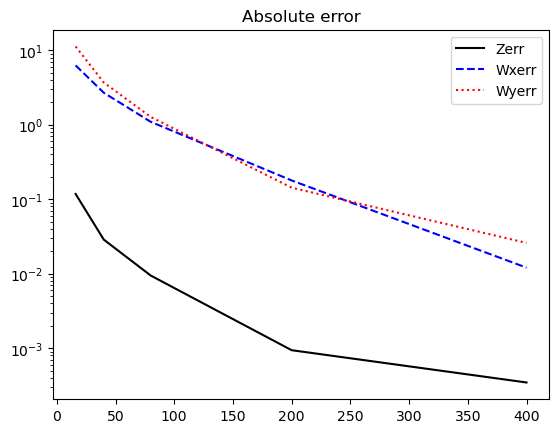

In [34]:
plt.semilogy(nv, Zerr, '-k', label='Zerr')
plt.semilogy(nv, Wxerr, '--b', label='Wxerr')
plt.semilogy(nv, Wyerr, ':r', label='Wyerr')

plt.title('Absolute error')
plt.legend()
plt.show()